In [1]:
import torch
import torch.nn.functional as F
import requests
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import logging
logger = logging.getLogger(__name__)

func_to_enable_grad = '_sample'
setattr(LlavaForConditionalGeneration, func_to_enable_grad, torch.enable_grad(getattr(LlavaForConditionalGeneration, func_to_enable_grad)))

C:\Users\Dreamcore\anaconda3\envs\fyp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    attn_implementation = "eager"
).to(0)

#--------------------------------------------------
model.vision_tower.config.output_attentions = True

# set hooks to get attention weights
model.enc_attn_weights = []
#outputs: attn_output, attn_weights, past_key_value
def forward_hook(module, inputs, output): 
    if output[1] is None:
        logger.error(
            ("Attention weights were not returned for the encoder. "
            "To enable, set output_attentions=True in the forward pass of the model. ")
        )
        return output
    
    output[1].requires_grad_(True)
    output[1].retain_grad()
    model.enc_attn_weights.append(output[1].detach().cpu())
    return output

hooks_pre_encoder, hooks_encoder = [], []
for layer in model.language_model.layers:
    hook_encoder_layer = layer.self_attn.register_forward_hook(forward_hook)
    hooks_pre_encoder.append(hook_encoder_layer)

model.enc_attn_weights_vit = []

def forward_hook_image_processor(module, inputs, output): 
    if output[1] is None:
        logger.warning(
            ("Attention weights were not returned for the vision model. "
             "Relevancy maps will not be calculated for the vision model. " 
             "To enable, set output_attentions=True in the forward pass of vision_tower. ")
        )
        return output

    output[1].requires_grad_(True)
    output[1].retain_grad()
    model.enc_attn_weights_vit.append(output[1])
    return output

hooks_pre_encoder_vit = []
for layer in model.vision_tower.vision_model.encoder.layers:
    hook_encoder_layer_vit = layer.self_attn.register_forward_hook(forward_hook_image_processor)
    hooks_pre_encoder_vit.append(hook_encoder_layer_vit)
#--------------------------------------------------

processor = AutoProcessor.from_pretrained(model_id)

if model.language_model.config.model_type == "gemma":
    eos_token_id = processor.tokenizer('<end_of_turn>', add_special_tokens=False).input_ids[0]
else:
    eos_token_id = processor.tokenizer.eos_token_id

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is the colour of this object?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

# image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
# raw_image = Image.open(requests.get(image_file, stream=True).raw)
image_file = r"C:\Users\Dreamcore\Downloads\61-gPGG7umL._UF894,1000_QL80_.jpg"
raw_image = Image.open(image_file).convert("RGB")
inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(0, torch.float16)

output = model.generate(
    **inputs, 
    max_new_tokens=200, 
    do_sample=False,
    use_cache=True,
    output_attentions=True,
    output_hidden_states=True,
    return_dict_in_generate=True,
    output_scores=True,
    eos_token_id=eos_token_id
)

for h in hooks_pre_encoder:
    h.remove()
for h in hooks_pre_encoder_vit:
    h.remove()

print(processor.decode(output.sequences[0], skip_special_tokens=True))

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.43it/s]
C:\Users\Dreamcore\anaconda3\envs\fyp\Lib\site-packages\torch\nn\modules\module.py:1355: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


USER:  
What is the colour of this object? ASSISTANT: The object is red in colour.


In [3]:
# output.sequences[0] is a tensor of shape [604]
tokens = output.sequences[0].tolist()  # convert to Python list

# Decode each token individually
decoded_tokens = [processor.decode([t]) for t in tokens]

# Optionally, print
for i, tok in enumerate(decoded_tokens):
    print(f"{i}: {repr(tok)}")

0: '<s>'
1: 'US'
2: 'ER'
3: ':'
4: ''
5: '<image>'
6: '<image>'
7: '<image>'
8: '<image>'
9: '<image>'
10: '<image>'
11: '<image>'
12: '<image>'
13: '<image>'
14: '<image>'
15: '<image>'
16: '<image>'
17: '<image>'
18: '<image>'
19: '<image>'
20: '<image>'
21: '<image>'
22: '<image>'
23: '<image>'
24: '<image>'
25: '<image>'
26: '<image>'
27: '<image>'
28: '<image>'
29: '<image>'
30: '<image>'
31: '<image>'
32: '<image>'
33: '<image>'
34: '<image>'
35: '<image>'
36: '<image>'
37: '<image>'
38: '<image>'
39: '<image>'
40: '<image>'
41: '<image>'
42: '<image>'
43: '<image>'
44: '<image>'
45: '<image>'
46: '<image>'
47: '<image>'
48: '<image>'
49: '<image>'
50: '<image>'
51: '<image>'
52: '<image>'
53: '<image>'
54: '<image>'
55: '<image>'
56: '<image>'
57: '<image>'
58: '<image>'
59: '<image>'
60: '<image>'
61: '<image>'
62: '<image>'
63: '<image>'
64: '<image>'
65: '<image>'
66: '<image>'
67: '<image>'
68: '<image>'
69: '<image>'
70: '<image>'
71: '<image>'
72: '<image>'
73: '<image>'
7

# Visualise ViT attention

In [4]:
model.enc_attn_weights_vit[4].shape

torch.Size([1, 16, 577, 577])

torch.Size([577, 577])


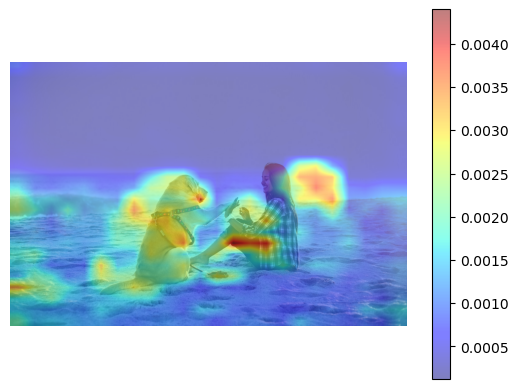

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

attn_avg = model.enc_attn_weights_vit[4][0].mean(dim=0)
print(attn_avg.shape)
cls_attn = attn_avg[0, 1:]  # exclude CLS itself
H, W = 24, 24  # 336 / 14
heatmap = cls_attn.reshape(H, W).detach().cpu().numpy()

# Assuming heatmap shape [H, W]
heatmap_tensor = torch.tensor(heatmap[None, None], dtype=torch.float32)
heatmap_full = F.interpolate(heatmap_tensor, size=(raw_image.size[1], raw_image.size[0]), mode='bilinear')[0,0].numpy()

image = Image.open(image_file).convert("RGB")
plt.imshow(image)
plt.imshow(heatmap_full, cmap='jet', alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

# Visualize LLM attention 
## During first forward pass when attn weights are input_token_len by input_token_len

In [30]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [6]:
print(f"attn_weights has length: {len(model.enc_attn_weights)}")
print(f"no. of forward passes = {len(model.enc_attn_weights)}/32 = {int(len(model.enc_attn_weights)/32)}")

# First forward pass, first layer
print(model.enc_attn_weights[0].shape) # [batch, head, no. of tokens, no. of tokens]

print(model.enc_attn_weights[51].shape)

attn_weights has length: 288
no. of forward passes = 288/32 = 9
torch.Size([1, 32, 599, 599])
torch.Size([1, 32, 1, 600])


torch.Size([599, 599])


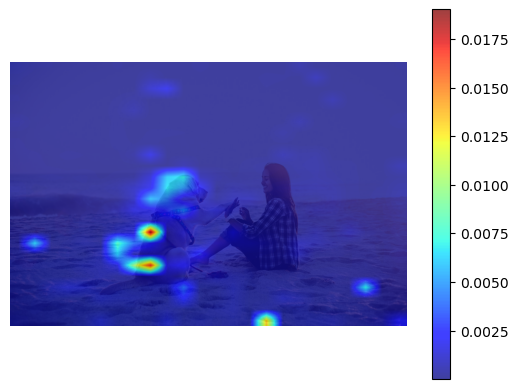

In [7]:
# Model starts generating tokens after "...ASSISTANT:"
attn_avg = model.enc_attn_weights[11][0].mean(dim=0)
print(attn_avg.shape)
cls_attn = attn_avg[592, 5:581]  # exclude CLS itself
H, W = 24, 24  # 336 / 14
heatmap = cls_attn.reshape(H, W).detach().cpu().numpy()

# Assuming heatmap shape [H, W]
heatmap_tensor = torch.tensor(heatmap[None, None], dtype=torch.float32)
heatmap_full = F.interpolate(heatmap_tensor, size=(raw_image.size[1], raw_image.size[0]), mode='bilinear')[0,0].numpy()

image = Image.open(image_file).convert("RGB")
plt.imshow(image)
plt.imshow(heatmap_full, cmap='jet', alpha=0.75)
plt.axis('off')
plt.colorbar()
plt.show()

# Attention Rollout
## During first forward pass when attn weights are input_token_len by input_token_len

In [68]:
def attention_rollout_function(attn_maps):
    attn_rollout = []
    device = attn_maps[0].device
    batch_size, _, seq_len, _ = attn_maps[0].shape
    
    # Identity matrix for self-attention
    I = torch.eye(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len, seq_len)

    prod = I.clone()
    
    for i, attn_map in enumerate(attn_maps):
        # Average over heads → [batch, seq_len, seq_len]
        attn_map = attn_map.mean(dim=1)
        
        # Add identity and multiply
        prod = prod @ (attn_map + I)
        
        # Normalize across sequence dimension
        prod = prod / prod.sum(dim=-1, keepdim=True)
        
        attn_rollout.append(prod)

    return attn_rollout

In [69]:
model.enc_attn_weights[32].shape

torch.Size([1, 32, 1, 600])

In [70]:
rollout = attention_rollout_function(model.enc_attn_weights[0:32])

In [71]:
rollout[0][0].shape

torch.Size([599, 599])

In [86]:
topk_vals, topk_inds = torch.topk(rollout[5][0, 598], 10)

In [87]:
topk_inds

tensor([  0, 598, 572, 390, 506, 582, 593, 495, 597, 583])

In [88]:
for i in topk_inds:
    print(repr(decoded_tokens[i.item()]))

'<s>'
':'
'<image>'
'<image>'
'<image>'
'\n'
'?'
'<image>'
'ANT'
'What'


# Visualise attention for subsequent forward passes

In [312]:
attn_weight = model.enc_attn_weights[287][0].mean(dim=0)
attn_weight.shape

torch.Size([1, 607])

In [315]:
topk_vals, topk_inds = torch.topk(attn_weight, 25)

In [316]:
topk_inds

tensor([[  0, 590, 606, 597, 605, 599, 595, 603, 598, 582, 593, 604,  62, 572,
         600, 596, 602, 592, 594, 583, 589, 586, 588, 506, 390]])

In [319]:
topk_vals

tensor([[0.4055, 0.1857, 0.0706, 0.0244, 0.0188, 0.0168, 0.0152, 0.0136, 0.0134,
         0.0121, 0.0100, 0.0086, 0.0073, 0.0073, 0.0072, 0.0069, 0.0067, 0.0058,
         0.0055, 0.0052, 0.0046, 0.0042, 0.0037, 0.0036, 0.0035]],
       dtype=torch.float16)

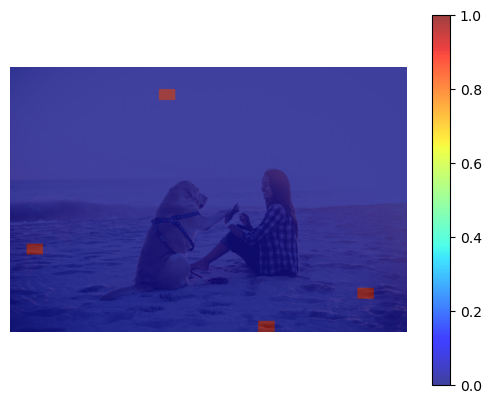

In [317]:
heatmap = [0 for i in range(576)]

for i in topk_inds[0]:
    if repr(decoded_tokens[i.item()]) == "'<image>'":
        heatmap[i.item()-5] = 1

H, W = 24, 24  # 336 / 14
heatmap = torch.tensor(heatmap)
heatmap = heatmap.reshape(H, W).detach().cpu().numpy()

# Assuming heatmap shape [H, W]
heatmap_tensor = torch.tensor(heatmap[None, None], dtype=torch.float32)
heatmap_full = F.interpolate(heatmap_tensor, size=(raw_image.size[1], raw_image.size[0]), mode='nearest-exact')[0,0].numpy()

image = Image.open(image_file).convert("RGB")
plt.imshow(image)
plt.imshow(heatmap_full, cmap='jet', alpha=0.75)
plt.axis('off')
plt.colorbar()
plt.show()

torch.Size([1, 607])


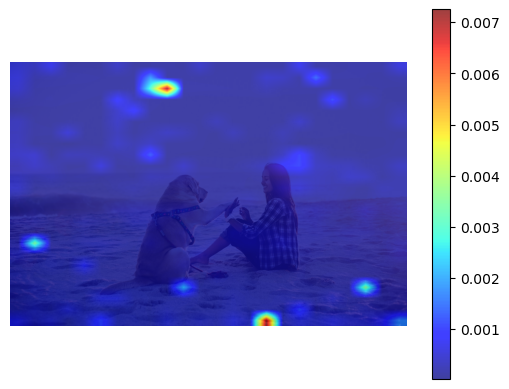

In [318]:
# Model starts generating tokens after "...ASSISTANT:"
attn_avg = attn_weight
print(attn_avg.shape)
cls_attn = attn_avg[0, 5:581]  # exclude CLS itself
H, W = 24, 24  # 336 / 14
heatmap = cls_attn.reshape(H, W).detach().cpu().numpy()

# Assuming heatmap shape [H, W]
heatmap_tensor = torch.tensor(heatmap[None, None], dtype=torch.float32)
heatmap_full = F.interpolate(heatmap_tensor, size=(raw_image.size[1], raw_image.size[0]), mode='bilinear')[0,0].numpy()

image = Image.open(image_file).convert("RGB")
plt.imshow(image)
plt.imshow(heatmap_full, cmap='jet', alpha=0.75)
plt.axis('off')
plt.colorbar()
plt.show()

# Attention relevancy testing

In [4]:
device = "cuda"
input_ids = inputs.input_ids
output_ids = output.sequences.reshape(-1)[input_ids.shape[-1]:].tolist() 
torch.cuda.empty_cache()

for target_index in tqdm(range(len(output.scores)), desc="Building relevancy maps"):
    token_logits = output.scores[target_index]
    token_id = torch.tensor(output_ids[target_index]).to(device)

    token_id_one_hot = torch.nn.functional.one_hot(token_id, num_classes=token_logits.size(-1)).float()
    token_id_one_hot = token_id_one_hot.view(1, -1)
    token_id_one_hot.requires_grad_(True)

    # Compute loss and backpropagate to get gradients on attention weights
    model.zero_grad()
    token_logits.backward(gradient=token_id_one_hot)

    for i, blk in enumerate(model.enc_attn_weights):
        grad = blk.grad.float().detach()
        print(grad)
        break
    
    break

Building relevancy maps:   0%|                                                                   | 0/3 [00:30<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 28.43 GiB is allocated by PyTorch, and 1.99 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Hidden states/concepts

In [25]:
print(f"No. of forward passes: {len(output.hidden_states)}")
print(f"No. of hidden states in each forward pass: {len(output.hidden_states[0])}")
print(f"Shape of 1 hidden state in first forward pass: {output.hidden_states[0][24].shape}")

logits = model.lm_head(output.hidden_states[3][17])
# Decode them
topk = torch.topk(logits, k=10, dim=-1)
for ids in topk.indices:
    print(processor.tokenizer.batch_decode(ids))

No. of forward passes: 8
No. of hidden states in each forward pass: 33
Shape of 1 hidden state in first forward pass: torch.Size([1, 596, 4096])
['color colour white色 red Color blackcolor blue pur']
